In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from common import collect_results, normalize_region_name
from pathlib import Path
from matplotlib import pyplot as plt

In [3]:
ROOT = Path("ycsb")

def get_matcher(prefix):
    def matcher(p: Path):   
        import re
        pattern = re.compile(prefix + r"-hot(\d+)-(\w)-mr(\d+)-([\d-]+)")
        match = pattern.match(p.name)
        if not match:
            return None

        print("Found result:", p.name)
        hot = int(match.group(1))
        return {
            "hot": 1000000 if hot == 0 else hot,
            "workload": str(match.group(2)),
            "mr": int(match.group(3)),
            "suffix": str(match.group(4)),
        }
    
    return matcher

# Throughput & Error


Collect the results

In [4]:
SYSTEMS = ["sunstorm", "aurora-global", "aurora-eventual", "yugabyte"]
HOTS = [100000, 1000]
RENEW_CACHE = False

# RMW

rmw_sunstorm_matcher = get_matcher("ycsb-throughput-sunstorm")
rmw_sunstorm_throughput_df = collect_results(
    ROOT / "rmw-sunstorm",
    rmw_sunstorm_matcher,
    RENEW_CACHE,
)

rmw_aurora_matcher = get_matcher("ycsb-throughput-aurora")
rmw_aurora_throughput_df = collect_results(
    ROOT / "rmw-aurora",
    rmw_aurora_matcher,
    RENEW_CACHE,
)

rmw_aurora_matcher = get_matcher("ycsb-throughput-aurora")
rmw_aurora_eventual_throughput_df = collect_results(
    ROOT / "rmw-aurora-eventual",
    rmw_aurora_matcher,
    RENEW_CACHE,
)

rmw_yugabyte_matcher = get_matcher("ycsb-throughput-yugabyte")
rmw_yugabyte_throughput_df = collect_results(
    ROOT / "rmw-yugabyte",
    rmw_yugabyte_matcher,
    RENEW_CACHE,
)

# Read-Heavy

read_heavy_sunstorm_matcher = get_matcher("ycsb-mixed-sunstorm")
read_heavy_sunstorm_throughput_df = collect_results(
    ROOT / "read-heavy-sunstorm",
    read_heavy_sunstorm_matcher,
    RENEW_CACHE,
)

read_heavy_aurora_matcher = get_matcher("ycsb-mixed-aurora")
read_heavy_aurora_throughput_df = collect_results(
    ROOT / "read-heavy-aurora",
    read_heavy_aurora_matcher,
    RENEW_CACHE,
)

read_heavy_aurora_matcher = get_matcher("ycsb-mixed-aurora")
read_heavy_aurora_eventual_throughput_df = collect_results(
    ROOT / "read-heavy-aurora-eventual",
    read_heavy_aurora_matcher,
    RENEW_CACHE,
)

read_heavy_yugabyte_matcher = get_matcher("ycsb-mixed-yugabyte")
read_heavy_yugabyte_throughput_df = collect_results(
    ROOT / "read-heavy-yugabyte",
    read_heavy_yugabyte_matcher,
    RENEW_CACHE,
)

# Read-Only

read_only_sunstorm_matcher = get_matcher("ycsb-read-only-sunstorm")
read_only_sunstorm_throughput_df = collect_results(
    ROOT / "read-only-sunstorm",
    read_only_sunstorm_matcher,
    RENEW_CACHE,
)

read_only_aurora_matcher = get_matcher("ycsb-read-only-aurora")
read_only_aurora_throughput_df = collect_results(
    ROOT / "read-only-aurora",
    read_only_aurora_matcher,
    RENEW_CACHE,
)

read_only_aurora_matcher = get_matcher("ycsb-read-only-aurora")
read_only_aurora_eventual_throughput_df = collect_results(
    ROOT / "read-only-aurora-eventual",
    read_only_aurora_matcher,
    RENEW_CACHE,
)

read_only_yugabyte_matcher = get_matcher("ycsb-read-only-yugabyte")
read_only_yugabyte_throughput_df = collect_results(
    ROOT / "read-only-yugabyte",
    read_only_yugabyte_matcher,
    RENEW_CACHE,
)


Combine the results

## Throughput

In [5]:
throughput_df = pd.concat([
    rmw_sunstorm_throughput_df.assign(system="sunstorm", workload="RMW"),
    rmw_aurora_throughput_df.assign(system="aurora-global", workload="RMW"),
    rmw_aurora_eventual_throughput_df.assign(system="aurora-eventual", workload="RMW"),
    rmw_yugabyte_throughput_df.assign(system="yugabyte", workload="RMW"),

    read_heavy_sunstorm_throughput_df.assign(system="sunstorm", workload="Read-Heavy"),
    read_heavy_aurora_throughput_df.assign(system="aurora-global", workload="Read-Heavy"),
    read_heavy_aurora_eventual_throughput_df.assign(system="aurora-eventual", workload="Read-Heavy"),
    read_heavy_yugabyte_throughput_df.assign(system="yugabyte", workload="Read-Heavy"),

    read_only_sunstorm_throughput_df.assign(system="sunstorm", workload="Read-Only"),
    read_only_aurora_throughput_df.assign(system="aurora-global", workload="Read-Only"),
    read_only_aurora_eventual_throughput_df.assign(system="aurora-eventual", workload="Read-Only"),
    read_only_yugabyte_throughput_df.assign(system="yugabyte", workload="Read-Only"),
])
normalize_region_name(throughput_df)
throughput_df

,path,region,hot,workload,mr,suffix,rejected,rejected.WorkloadF1,rejected.WorkloadF2,rejected.WorkloadF3,...,throughput.WorkloadC1,avg.WorkloadC1,p0.WorkloadC1,p25.WorkloadC1,p50.WorkloadC1,p75.WorkloadC1,p90.WorkloadC1,p95.WorkloadC1,p99.WorkloadC1,p100.WorkloadC1
0,ycsb/rmw-sunstorm/ycsb-throughput-sunstorm-hot...,3-ap-northeast-1-0,1000,RMW,10,20240808-223622,36079,18570.0,13433.0,4076.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ycsb/rmw-sunstorm/ycsb-throughput-sunstorm-hot...,1-us-east-1-0,1000,RMW,10,20240808-223622,42220,25531.0,12637.0,4052.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ycsb/rmw-sunstorm/ycsb-throughput-sunstorm-hot...,2-eu-west-1-0,1000,RMW,10,20240808-223622,34793,19401.0,11780.0,3612.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ycsb/rmw-sunstorm/ycsb-throughput-sunstorm-hot...,3-ap-northeast-1-0,1000,RMW,5,20240808-223622,41301,23125.0,13989.0,4187.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ycsb/rmw-sunstorm/ycsb-throughput-sunstorm-hot...,1-us-east-1-0,1000,RMW,5,20240808-223622,47064,31077.0,11931.0,4056.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,ycsb/read-only-yugabyte/ycsb-read-only-yugabyt...,1-us-east-1-0,1000,Read-Only,10,20240626-143601,0,NaN,NaN,NaN,...,2863.9,99.133152,58.294,85.726,97.335,110.5085,123.9710,132.71400,150.88058,235.034
26,ycsb/read-only-yugabyte/ycsb-read-only-yugabyt...,2-eu-west-1-0,1000,Read-Only,10,20240626-143601,0,NaN,NaN,NaN,...,2870.6,107.238877,68.577,95.015,105.756,117.7750,129.8659,137.74900,154.45396,302.999
27,ycsb/read-only-yugabyte/ycsb-read-only-yugabyt...,3-ap-northeast-1-0,1000,Read-Only,50,20240626-143601,0,NaN,NaN,NaN,...,563.0,14.176207,8.142,11.966,13.691,15.8840,18.2400,19.78065,22.94013,59.097
28,ycsb/read-only-yugabyte/ycsb-read-only-yugabyt...,1-us-east-1-0,1000,Read-Only,50,20240626-143601,0,NaN,NaN,NaN,...,792.6,23.002758,12.034,19.296,22.573,26.1970,29.8130,32.15915,36.98366,61.721


Compute the error rates

In [6]:
columns = ['ood_index_page', 'ood_tuple', 'other_aborts', 'ood_table', 'deadlock', 'completed'] 
error_df = throughput_df.groupby(["workload","hot", "system", "mr"]).sum()[columns]
error_df["outdated index page"] = error_df["ood_index_page"] / error_df["completed"] * 100
error_df["outdated table"] = error_df["ood_table"] / error_df["completed"] * 100
error_df["outdated tuple"] = error_df["ood_tuple"] / error_df["completed"] * 100
error_df["other aborts"] = error_df["other_aborts"] / error_df["completed"] * 100
error_df["deadlock"] = error_df["deadlock"] / error_df["completed"] * 100
error_df["pct"] = error_df["deadlock"] + error_df["outdated index page"] + error_df["outdated table"] + error_df["outdated tuple"] + error_df["other aborts"]
error_df.loc[("RMW", 1000, "sunstorm")] # type: ignore

,ood_index_page,ood_tuple,other_aborts,ood_table,deadlock,completed,outdated index page,outdated table,outdated tuple,other aborts,pct
mr,,,,,,,,,,,
0,0,0,44314,0,0.000000,2931750,0.000000,0.0,0.000000,1.511520,1.511520
5,9254,31234,102399,0,0.010116,1245535,0.742974,0.0,2.507677,8.221286,11.482054
10,1035,30880,81177,0,0.010557,824069,0.125596,0.0,3.747259,9.850753,13.734165
15,1301,26738,66856,0,0.037153,584069,0.222748,0.0,4.577884,11.446593,16.284377
50,3,30241,69584,0,0.000000,309921,0.000968,0.0,9.757648,22.452173,32.210789


Create plots for RMW and Read-Heavy

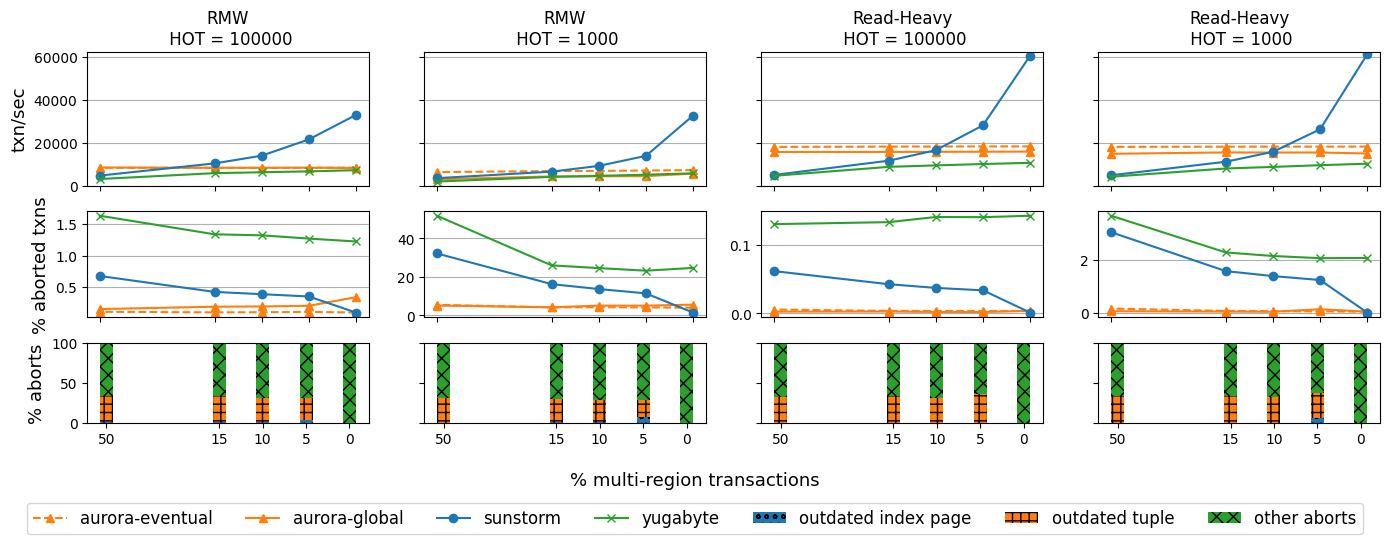

In [7]:
from matplotlib.ticker import ScalarFormatter
from matplotlib.gridspec import GridSpec

FONT_SIZE_AXES = 13
FONT_SIZE_LEGEND = 12

xticks = [0, 5, 10, 15, 50]
xticklabels = [0, 5, 10, 15, 50]
legend_handles = []
legend_labels = []
abort_colors = ["C0", "C1", "C2"]
abort_patterns = ["oo", "++", "xx"]
error_columns = ['outdated index page', 'outdated tuple', 'other aborts'] 
workloads = ["RMW", "Read-Heavy"]

fig = plt.figure(figsize=(14, 5))
gs = GridSpec(3, 4, figure=fig, height_ratios=[2.5, 2, 1.5], width_ratios=[1, 1, 1, 1])

for w, workload in enumerate(workloads):
    for h,hot in enumerate([100000, 1000]):
        ax = plt.subplot(gs[0, (w*2 + h)])
        hot_throughput_df = throughput_df[(throughput_df.hot == hot) & (throughput_df.workload == workload)]
        hot_throughput_df.pivot_table(
            index=["mr"], columns=["system"], values="throughput", aggfunc="sum"
        ).plot(
            ax=ax,
            style=["^--", "^-", "o-", "x-"],
            color=["C1", "C1", "C0", "C2"],
            ylim=(0, 62000),
            rot=0,
            legend=False,
        )
        ax.margins(x=0.05)
        ax.set_ylabel("txn/sec", fontsize=FONT_SIZE_AXES)
        ax.set_title(f"{workload}\n HOT = {hot}")
        ax.set_xscale("symlog", linthresh=20)
        ax.set_xticks(xticks)
        ax.set_xticklabels([])
        ax.grid(axis="y")
        ax.invert_xaxis()
        ax.set_xlabel("")
        
        if w+h == 0:
            handles, labels = ax.get_legend_handles_labels()
            legend_handles += handles
            legend_labels += labels
        else:
            ax.set_yticklabels([])
            ax.set_ylabel("")
        

        ax = plt.subplot(gs[1, h+2*w])

        error_df.unstack(level=1)["pct"].loc[workload][hot].unstack(level=0)\
            .set_index(np.array(xticks))\
            .plot(
                ax=ax,
                style=["^--", "^-", "o-", "x-"],
                color=["C1", "C1", "C0", "C2"],
                rot=0,
                legend=False,
            )

        ax.margins(x=0.05)
        ax.set_xscale("symlog", linthresh=20)
        ax.set_xticks(xticks)
        ax.set_xticklabels([])
        ax.set_ylabel("% aborted txns", fontsize=FONT_SIZE_AXES)
        ax.grid(axis="y")
        ax.invert_xaxis()
        ax.get_yaxis().set_major_formatter(ScalarFormatter())
        if w+h != 0:
            ax.set_ylabel("")

        xticks_hack = [0, 5, 10, 15, 28]
        ax = plt.subplot(gs[2, h+2*w])
        sunstorm_error_df = error_df.loc[(workload, hot, "sunstorm",)].copy() # type: ignore
        error_columns_pct = [f"{col}" for col in error_columns]
        bottom = None
        for col, color, pattern in zip(error_columns_pct, abort_colors, abort_patterns):
            error = sunstorm_error_df[col] / sunstorm_error_df["pct"] * 100
            ax.bar(
                xticks_hack,
                error,
                bottom=bottom, # type: ignore
                label=col,
                width=1.5,
                facecolor=color,
                hatch=pattern,
            )
            if bottom is None:
                bottom = error
            else:
                bottom += error
        ax.set_ylim(0, 100)
        ax.set_xticks(xticks_hack)
        ax.set_xticklabels(xticklabels)
        ax.set_ylabel("% aborts", fontsize=FONT_SIZE_AXES)
        ax.invert_xaxis()
        if w+h == 0:
            handles, labels = ax.get_legend_handles_labels()
            legend_handles += handles
            legend_labels += labels
        else:
            ax.set_ylabel("")
            ax.set_yticklabels([])

fig.supxlabel("% multi-region transactions", fontsize=FONT_SIZE_AXES)
fig.legend(legend_handles, legend_labels, ncol=7, bbox_to_anchor=(0.5, 0), loc="upper center", fontsize=FONT_SIZE_LEGEND)
# fig.legend(legend_handles, legend_labels, ncol=4, loc="lower center", bbox_to_anchor=(0.5, 1), fontsize=13, fontsize=FONT_SIZE_LEGEND)
plt.tight_layout()
plt.savefig("output/throughput-error.pdf", bbox_inches="tight")


Plot for Read-only

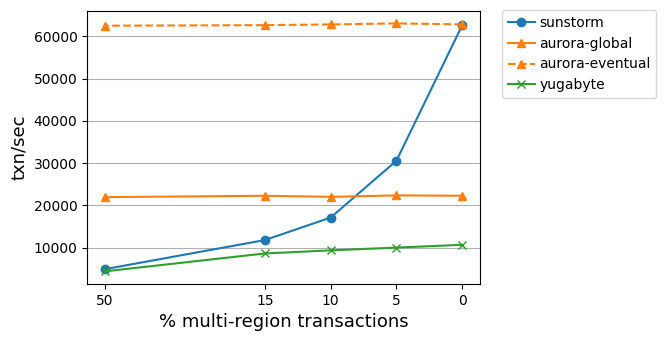

In [8]:
from matplotlib.lines import Line2D

FONT_SIZE_AXES = 13
FONT_SIZE_LEGEND = 12

fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))

hot_df = throughput_df[(throughput_df.hot == 1000) & (throughput_df.workload == "Read-Only")]
pivotted = hot_df.pivot_table(
    index=["mr"], columns=["system"], values="throughput", aggfunc="sum"
)[SYSTEMS].plot(
    title="",
    style=["o-", "^-", "^--", "x-"],
    color=["C0", "C1", "C1", "C2"],
    ax = ax,
    legend=False,
)
ax.set_xscale("symlog", linthresh=20)
ax.set_xticks([0, 5, 10, 15, 50])
ax.set_xticklabels([0, 5, 10, 15, 50])
ax.margins(x=0.05)
ax.grid(axis="y")
ax.set_xlabel("% multi-region transactions", fontsize=FONT_SIZE_AXES)
ax.set_ylabel("txn/sec", fontsize=FONT_SIZE_AXES)
ax.invert_xaxis()

fig.legend(handles=[
        Line2D([0], [0],  marker='o', linestyle='-', color='C0', markerfacecolor='C0', label='sunstorm'),
        Line2D([0], [0],  marker='^', linestyle='-',color='C1', markerfacecolor='C1', label='aurora-global'),
        Line2D([0], [0],  marker='^', linestyle='--',color='C1', markerfacecolor='C1', label='aurora-eventual'),
        Line2D([0], [0],  marker='x', linestyle='-',color='C2', markerfacecolor='C2', label='yugabyte'),
    ], 
    title="",
    ncol=1,
    loc="upper left",
    handletextpad=0.3,
    bbox_to_anchor=(1, 0.98),
)
fig.tight_layout()
fig.savefig("output/micro-read-only.pdf", bbox_inches="tight")


# Latency

In [9]:
x = throughput_df[(throughput_df.workload == "RMW") & (throughput_df.hot == 100000) & (throughput_df.system == "aurora-global") & (throughput_df.mr == 5)]
x[["region", "p0.WorkloadF1", "p25.WorkloadF1", "p50.WorkloadF1", "p75.WorkloadF1", "p100.WorkloadF1"]]

,region,p0.WorkloadF1,p25.WorkloadF1,p50.WorkloadF1,p75.WorkloadF1,p100.WorkloadF1
3,3-ap-northeast-1-0,3328.704,4100.9855,4429.5625,4806.785,11098.243
4,1-us-east-1-0,1.924,9.6150,11.3690,12.621,157.520
5,2-eu-west-1-0,1792.367,2153.9000,2318.7380,2485.914,4815.397


In [10]:
fig, axes = plt.subplots(4, 3, figsize=(10, 8), sharey=True)

FONT_SIZE_TITLE = 11
FONT_SIZE_AXES = 11
FONT_SIZE_LEGEND = 11

labels = [
    "1 region\n",
    "2 regions\n",
    "3 regions\n",
]
ticks = np.arange(len(labels))

width = 0.5

def to_box(df, n):
    def extract(col_name):
        col = df[col_name]
        col = col[col.notna()]
        assert len(col) == 1, f"Exactly one value expected, but {col_name} =\n{col}"
        return col.iloc[0]

    return {
        'whislo': extract(f"p0.WorkloadF{n}"),
        'q1': extract(f"p25.WorkloadF{n}"),
        'med': extract(f"p50.WorkloadF{n}"),
        'q3': extract(f"p75.WorkloadF{n}"),
        'whishi': extract(f"p99.WorkloadF{n}"),
        'fliers': []
    }

legends = []
patterns = ["xx", "||", "++", "oo"]
colors = ["C0", "C1", "C3", "C2"]

for h, hot in enumerate([100000, 1000]):
    for m, mr in enumerate([5, 50]):
        hot_df = throughput_df[(throughput_df.hot == hot) & (throughput_df.workload == "RMW")]
        hot_label = hot
        for r, region in enumerate(["1-us-east-1", "2-eu-west-1", "3-ap-northeast-1"]):
            region_df = hot_df[hot_df.region.str.startswith(region)]

            ax = axes[(2*h) + m, r]
            for i, system in enumerate(SYSTEMS):
                system_df = region_df[region_df.system == system]
                boxes = [
                    to_box(system_df[system_df.mr == mr], 1),
                    to_box(system_df[system_df.mr == mr], 2),
                    to_box(system_df[system_df.mr == mr], 3),
                ]
                comps = ax.bxp(
                    boxes,
                    positions=ticks - width / 2 + i * width / (len(SYSTEMS) - 1),
                    showfliers=False,
                    manage_ticks=False,
                    patch_artist=True,
                    widths=0.13,
                    boxprops={
                        "facecolor": colors[i],
                        "linewidth": 0,
                        "hatch": patterns[i],
                    },
                    medianprops={
                        "color": "black",
                        "linewidth": 1,
                    },
                    whiskerprops={
                        "color": colors[i]
                    },
                )
                if m==0 and h==0 and r==0:
                    legends.append(comps["boxes"][0])

            ax.set_yscale("log")
            # ax.set_ylim(0.99, 15000)
            if h == 0 and m == 0:
                ax.set_title(region[2:], fontsize=FONT_SIZE_TITLE)
            if h == 1 and m == 1:
                ax.set_xticks(labels=labels, ticks=ticks)
            else:
                ax.set_xticks(labels=[], ticks=ticks)
         
            if r == 2:
                ax.set_ylabel(f"MR = {mr} \n HOT = {hot_label}", fontsize=FONT_SIZE_AXES)
                ax.yaxis.set_label_position("right")
            elif r == 0:
                ax.set_ylabel("")
            # ax.set_title(f"HOT = {hot_label} ({region[2:]})")

fig.legend(legends, SYSTEMS, ncol=4, bbox_to_anchor=(0.5, 0), loc="upper center", fontsize=FONT_SIZE_LEGEND)
fig.supylabel("Latency (ms)", fontsize=FONT_SIZE_AXES)
fig.tight_layout()
fig.savefig("output/ycsb-latency-multiple.pdf", bbox_inches="tight")


p0.WorkloadF1 19    3.534
Name: p0.WorkloadF1, dtype: float64
p25.WorkloadF1 19    4.896
Name: p25.WorkloadF1, dtype: float64
p50.WorkloadF1 19    5.425
Name: p50.WorkloadF1, dtype: float64
p75.WorkloadF1 19    6.01
Name: p75.WorkloadF1, dtype: float64
p99.WorkloadF1 19    10.69233
Name: p99.WorkloadF1, dtype: float64
p0.WorkloadF2 19    80.907
Name: p0.WorkloadF2, dtype: float64
p25.WorkloadF2 19    87.57075
Name: p25.WorkloadF2, dtype: float64
p50.WorkloadF2 19    158.5395
Name: p50.WorkloadF2, dtype: float64
p75.WorkloadF2 19    171.44925
Name: p75.WorkloadF2, dtype: float64
p99.WorkloadF2 19    259.195
Name: p99.WorkloadF2, dtype: float64
p0.WorkloadF3 19    156.716
Name: p0.WorkloadF3, dtype: float64
p25.WorkloadF3 19    166.71375
Name: p25.WorkloadF3, dtype: float64
p50.WorkloadF3 19    173.94
Name: p50.WorkloadF3, dtype: float64
p75.WorkloadF3 19    179.0375
Name: p75.WorkloadF3, dtype: float64
p99.WorkloadF3 19    346.27731
Name: p99.WorkloadF3, dtype: float64
p0.WorkloadF1 4  